<img width="400" src="https://nomeroff.net.ua/images/logo/nomeroff_net.svg" alt="Nomeroff Net. Automatic numberplate recognition system" align="left"/>

## The example demonstrates license plate number detection.

Before runing this demo, please download models from [https://nomeroff.net.ua/models/](https://nomeroff.net.ua/models/) to **./models/** directory. 

In [1]:
# Import all necessary libraries.
import os
import cv2
import numpy as np
import sys
import json
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# change this property
NOMEROFF_NET_DIR = os.path.abspath('../')

# specify the path to Mask_RCNN if you placed it outside Nomeroff-net project
MASK_RCNN_DIR = os.path.join(NOMEROFF_NET_DIR, 'Mask_RCNN')
MASK_RCNN_LOG_DIR = os.path.join(NOMEROFF_NET_DIR, 'logs')

sys.path.append(NOMEROFF_NET_DIR)

Also you may use .pb models for options detectors or OCR detectors. 
More about conversion and preparing for inference withit https://github.com/ria-com/nomeroff-net/blob/master/examples/inference_convert.ipynb.

In [2]:
# Import license plate recognition tools.
from NomeroffNet import  filters
from NomeroffNet import  RectDetector
from NomeroffNet import  TextDetector
from NomeroffNet import  OptionsDetector
from NomeroffNet import  Detector
from NomeroffNet import  textPostprocessing
from NomeroffNet import  textPostprocessingAsync

# Initialize npdetector with default configuration file.
nnet = Detector(MASK_RCNN_DIR, MASK_RCNN_LOG_DIR)
nnet.loadModel("latest")

rectDetector = RectDetector()

optionsDetector = OptionsDetector()
optionsDetector.load("latest")

# Initialize text detector.
textDetector = TextDetector({
    "eu_ua_2004_2015": {
        "for_regions": ["eu_ua_2015", "eu_ua_2004"],
        "model_path": "latest"
    },
    "eu_ua_1995": {
        "for_regions": ["eu_ua_1995"],
        "model_path": "latest"
    },
    "eu": {
        "for_regions": ["eu"],
        "model_path": "latest"
    },
    "ru": {
        "for_regions": ["ru", "eu-ua-fake-lnr", "eu-ua-fake-dnr"],
        "model_path": "latest" 
    },
    "kz": {
        "for_regions": ["kz"],
        "model_path": "latest"
    },
    "ge": {
        "for_regions": ["ge"],
        "model_path": "latest"
    }
})

Using TensorFlow backend.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead

Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



images/example1.jpeg


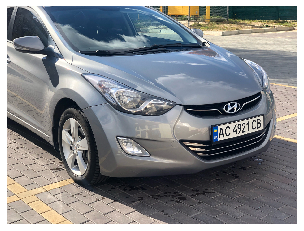

[[[1088.86876002  456.88526571]
  [1090.01622162  518.84819198]
  [ 874.48799556  577.83486437]
  [ 870.7772108   503.61916912]]]


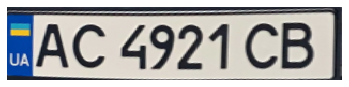

['eu_ua_2015']
[1]
['AC4921CB']
images/250030939.jpeg


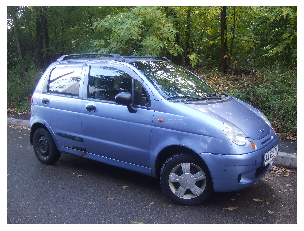

[[[1411.51881002  823.91985551]
  [1499.08604633  757.0922278 ]
  [1494.6099143   810.80581217]
  [1410.40410427  886.34337705]]]


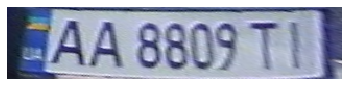

['eu_ua_2015']
[1]
['AA8809TI']
images/inx960x640.jpg


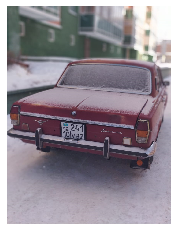

[[[287.05846163 614.65357003]
  [413.04936057 623.26833235]
  [411.888712   711.47762363]
  [286.00422207 692.66729755]]]


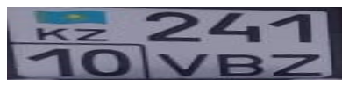

['kz']
[2]
['24110VBZ']
images/241458051.jpg


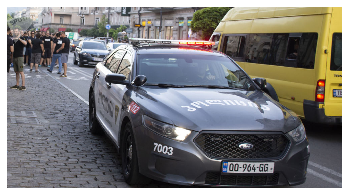

[[[644.0167403  461.09535197]
  [803.53845982 462.18053374]
  [795.64469262 496.01096462]
  [636.49349482 494.94995663]]]


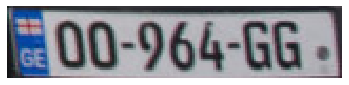

['eu']
[1]
['00964GG']
images/example2.jpeg


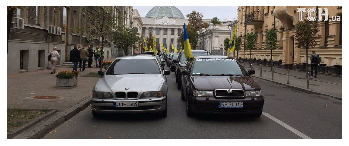

[[[839.1554658  380.36918758]
  [948.90920628 377.44242117]
  [952.37323831 404.        ]
  [842.23774568 404.        ]]

 [[526.72859857 381.29801663]
  [527.93097188 401.73836285]
  [425.08742803 403.02390715]
  [422.62566416 378.40626845]]]


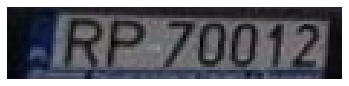

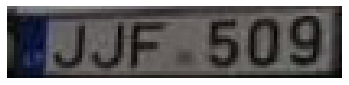

['eu', 'eu']
[1, 1]
['RP70012', 'JJF509']
images/20717578-39-full.jpg


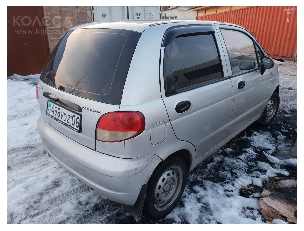

[[[166.43368114 387.74469232]
  [307.07821529 451.15001509]
  [303.73172441 519.19532956]
  [164.0771437  443.12332218]]]


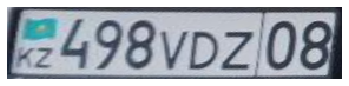

['kz']
[1]
['498VDZ08']
images/296023036.jpeg


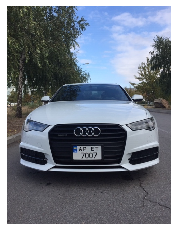

[[[279. 410.]
  [279. 451.]
  [189. 451.]
  [189. 410.]]]


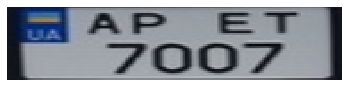

['kz']
[2]
['P7007']


In [3]:
# Walking through the ./examples/images/ directory and checking each of the images for license plates.
rootDir = 'images/'

max_img_w = 1600
for dirName, subdirList, fileList in os.walk(rootDir):
    for fname in fileList:
        img_path = os.path.join(dirName, fname)
        print(img_path)
        img = mpimg.imread(img_path)
        plt.axis("off")
        plt.imshow(img)
        plt.show()
         
        # corect size for better speed
        img_w = img.shape[1]
        img_h = img.shape[0]
        img_w_r = 1
        img_h_r = 1
        if img_w > max_img_w:
            resized_img = cv2.resize(img, (max_img_w, int(max_img_w/img_w*img_h)))
            img_w_r = img_w/max_img_w
            img_h_r = img_h/(max_img_w/img_w*img_h)
        else:
            resized_img = img

        NP = nnet.detect([resized_img]) 
        
        # Generate image mask.
        cv_img_masks = await filters.cv_img_mask_async(NP)
            
        # Detect points.
        arrPoints = await rectDetector.detectAsync(cv_img_masks, outboundHeightOffset=0, fixGeometry=True, fixRectangleAngle=10)
        print(arrPoints)
        arrPoints[..., 1:2] = arrPoints[..., 1:2]*img_h_r
        arrPoints[..., 0:1] = arrPoints[..., 0:1]*img_w_r
        
        # cut zones
        zones = await rectDetector.get_cv_zonesBGR_async(img, arrPoints)
        toShowZones = await rectDetector.get_cv_zonesRGB_async(img, arrPoints)
        for zone, points in zip(toShowZones, arrPoints):
            plt.axis("off")
            plt.imshow(zone)
            plt.show()
    
        # find standart
        regionIds, stateIds, countLines = optionsDetector.predict(zones)
        regionNames = optionsDetector.getRegionLabels(regionIds)
        print(regionNames)
        print(countLines)

        # find text with postprocessing by standart  
        textArr = textDetector.predict(zones, regionNames, countLines)
        textArr = await textPostprocessingAsync(textArr, regionNames)
        print(textArr)